In [2]:
import zipfile
import tensorflow as tf
import os
import gdown
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from PIL import Image
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [8]:
# https://drive.google.com/file/d/1KNyweNbteb38ugiCBcwy3kXACwVnT0lG/view?usp=sharing
import zipfile
id_file = '1KNyweNbteb38ugiCBcwy3kXACwVnT0lG'
output_file = 'Espectrogramas.zip'  # Nombre del archivo en Colab

gdown.download(f'https://drive.google.com/uc?id={id_file}', output_file)

Downloading...
From (original): https://drive.google.com/uc?id=1KNyweNbteb38ugiCBcwy3kXACwVnT0lG
From (redirected): https://drive.google.com/uc?id=1KNyweNbteb38ugiCBcwy3kXACwVnT0lG&confirm=t&uuid=a9d78f3b-e8a9-41fe-8460-000a3f14e72d
To: c:\Users\jpret\OneDrive\Escritorio\Pajarracos\Espectrogramas.zip
100%|██████████| 1.16G/1.16G [02:11<00:00, 8.83MB/s]


'Espectrogramas.zip'

In [9]:

# Descomprimir el archivo zip
zip_file = 'Espectrogramas.zip'
extract_dir = ''

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [10]:

base_dir = 'Entrenar'

# Función para convertir a RGB y normalizar una imagen
def convert_and_normalize(img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')  # Convertir a RGB si la imagen tiene canal alfa (RGBA)
    img_array = np.array(img)  # Convertir a numpy array
    img_array = img_array / 255.0  # Normalizar al rango [0, 1]
    img_array = (img_array * 255).astype(np.uint8)  # Convertir de nuevo a uint8
    img_normalized = Image.fromarray(img_array)  # Convertir de nuevo a imagen PIL
    img_normalized.save(img_path)  # Sobrescribir la imagen original

# Función para procesar todas las imágenes en una carpeta
def process_images_in_folder(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.png'):  # Asumiendo que las imágenes son archivos PNG
                img_path = os.path.join(root, file)
                convert_and_normalize(img_path)
                print(f"Procesando {img_path}")

# Normalizar imágenes en la carpeta 'train'
print("Procesando imágenes en la carpeta 'train'...")
for bird_folder in os.listdir(base_dir):
    bird_dir = os.path.join(base_dir, bird_folder)
    if os.path.isdir(bird_dir):
        process_images_in_folder(bird_dir)

Procesando imágenes en la carpeta 'train'...
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_1.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_2.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_3.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_4.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_5.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_6.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC113984_segment_7.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC114060_segment_1.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC114060_segment_2.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC114060_segment_3.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC114060_segment_4.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC114060_segment_5.png
Procesando Entrenar\bncfly_5_segundos_espectrograma\XC1

In [3]:
base_dir = 'Entrenar'
image_paths = []
labels = []
label_map = {}

for bird_folder in os.listdir(base_dir):
    bird_dir = os.path.join(base_dir, bird_folder)
    if os.path.isdir(bird_dir):
        # Crear un label map
        if bird_folder not in label_map:
            label_map[bird_folder] = len(label_map)
        label = label_map[bird_folder]
        for file in os.listdir(bird_dir):
            if file.endswith('.png'):
                img_path = os.path.join(bird_dir, file)
                image_paths.append(img_path)
                labels.append(label)

In [4]:
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)


# Crear un generador de datos
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, dim=(224, 224), n_channels=3, n_classes=10, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_paths_temp = [self.image_paths[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_paths_temp, labels_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, labels_temp):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, (img_path, label) in enumerate(zip(image_paths_temp, labels_temp)):
            img = Image.open(img_path)
            img = img.resize(self.dim)
            img_array = np.array(img)
            if img_array.shape == (224, 224, 4):  # En caso de tener canal alfa
                img_array = img_array[..., :3]  # Remover el canal alfa
            X[i,] = img_array / 255.0  # Normalizar

            y[i] = label

        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)


In [5]:

# Parámetros
batch_size = 16
epochs = 50
n_classes = len(label_map)

# Crear instancias del generador de datos
train_generator = DataGenerator(train_paths, train_labels, batch_size=batch_size, n_classes=n_classes)
val_generator = DataGenerator(val_paths, val_labels, batch_size=batch_size, n_classes=n_classes)
test_generator = DataGenerator(test_paths, test_labels, batch_size=batch_size, n_classes=n_classes, shuffle=False)

# Crear la arquitectura de ResNet50 sin pesos preentrenados
model = ResNet50(weights=None, input_shape=(224, 224, 3), classes=n_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# Entrenar el modelo
model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy}')

Epoch 1/50
1706/1706 [==============================] - 1505s 874ms/step - loss: 1.4297 - accuracy: 0.5365 - val_loss: 1.8594 - val_accuracy: 0.5211
Epoch 2/50
1706/1706 [==============================] - 1548s 907ms/step - loss: 0.9176 - accuracy: 0.7031 - val_loss: 0.9428 - val_accuracy: 0.6947
Epoch 3/50
1706/1706 [==============================] - 1507s 883ms/step - loss: 0.7386 - accuracy: 0.7625 - val_loss: 0.7516 - val_accuracy: 0.7602
Epoch 4/50
1706/1706 [==============================] - 1466s 859ms/step - loss: 0.6267 - accuracy: 0.7986 - val_loss: 0.8116 - val_accuracy: 0.7449
Epoch 5/50
1706/1706 [==============================] - 1508s 884ms/step - loss: 0.5244 - accuracy: 0.8298 - val_loss: 1.3799 - val_accuracy: 0.6722
Epoch 6/50
1706/1706 [==============================] - 1474s 864ms/step - loss: 0.4430 - accuracy: 0.8556 - val_loss: 0.6207 - val_accuracy: 0.8214
Epoch 7/50
1706/1706 [==============================] - 1488s 872ms/step - loss: 0.3795 - accuracy: 0.8765

In [10]:
print(f'Test Loss: {test_loss}')

Test Loss: 0.7293829321861267


In [7]:
model.save('resnet-1180.h5')

In [28]:
acc= [0.5365, 0.7031, 0.7625, 0.7986, 0.8298, 0.8556, 0.8765, 0.8987, 0.9171, 0.9335, 0.9457, 0.9554, 0.9639, 0.9679, 0.9727, 0.976, 0.98, 0.9781, 0.9828, 0.9833, 0.9842, 0.9866, 0.9866, 0.9868, 0.9881, 0.9887, 0.9874, 0.9884, 0.9913, 0.9899, 0.991, 0.9903, 0.9905, 0.992, 0.992, 0.9926, 0.9924, 0.9925, 0.9937, 0.9926, 0.9921, 0.9938, 0.9944, 0.993, 0.9938, 0.9955, 0.9941, 0.9942, 0.9947, 0.9951]
val_acc= [0.5211, 0.6947, 0.7602, 0.7449, 0.6722, 0.8214, 0.7512, 0.8453, 0.8725, 0.8299, 0.8056, 0.837, 0.8618, 0.865, 0.8441, 0.8835, 0.8783, 0.844, 0.8631, 0.8554, 0.8749, 0.8543, 0.8337, 0.8617, 0.8785, 0.8003, 0.8846, 0.8609, 0.8738, 0.8796, 0.8827, 0.8816, 0.8714, 0.8654, 0.8717, 0.882, 0.8867, 0.8709, 0.8729, 0.8798, 0.8895, 0.8685, 0.8888, 0.8906, 0.888, 0.8771, 0.8826, 0.8782, 0.8763, 0.887]
loss= [1.4297, 0.9176, 0.7386, 0.6267, 0.5244, 0.443, 0.3795, 0.3054, 0.2503, 0.204, 0.1625, 0.1317, 0.1065, 0.0953, 0.0804, 0.0716, 0.0591, 0.0666, 0.0508, 0.0489, 0.0481, 0.0415, 0.0411, 0.0386, 0.0354, 0.0354, 0.0387, 0.0358, 0.0265, 0.0312, 0.0304, 0.0279, 0.0299, 0.026, 0.025, 0.0221, 0.0239, 0.023, 0.0199, 0.0235, 0.0234, 0.0206, 0.0178, 0.0221, 0.0208, 0.0159, 0.018, 0.0181, 0.0168, 0.0149]
val_loss= [1.8594, 0.9428, 0.7516, 0.8116, 1.3799, 0.6207, 0.9356, 0.5003, 0.4271, 0.6166, 0.7896, 0.6053, 0.5908, 0.5187, 0.7151, 0.5497, 0.6041, 0.7961, 0.6667, 0.7087, 0.6539, 0.7051, 0.9932, 0.6956, 0.623, 1.2156, 0.5568, 0.7677, 0.6732, 0.6436, 0.6383, 0.6125, 0.6852, 0.7957, 0.6798, 0.6601, 0.5969, 0.709, 0.6774, 0.6514, 0.6347, 0.7392, 0.6082, 0.6155, 0.6338, 0.743, 0.6508, 0.7376, 0.7328, 0.6503]

In [29]:
len(loss),(len(val_loss)),len(acc),len(val_acc)

(50, 50, 50, 50)

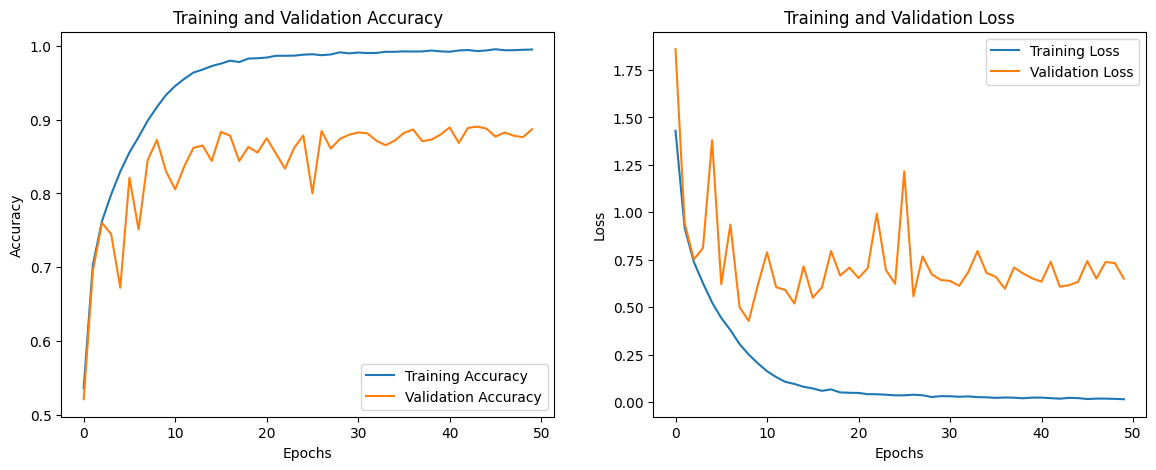

In [31]:
import matplotlib.pyplot as plt

def plot_training_history_from_data(acc, val_acc, loss, val_loss):
    # Crear las figuras y los ejes para las gráficas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Graficar la precisión
    ax1.plot(acc, label='Training Accuracy')
    ax1.plot(val_acc, label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Graficar la pérdida
    ax2.plot(loss, label='Training Loss')
    ax2.plot(val_loss, label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Mostrar las gráficas
    plt.savefig('stats.png')
    plt.show()
plot_training_history_from_data(acc, val_acc, loss, val_loss)

In [37]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import recall_score, f1_score,precision_score


# Supongamos que tienes un generador llamado 'data_generator' que genera lotes de datos de prueba
# y que tu modelo se llama 'model'

# Inicializar listas para almacenar las predicciones y las etiquetas verdaderas
y_pred_list = []
y_true_list = []

# Obtener predicciones y etiquetas verdaderas para cada lote generado por el generador
for X_batch, y_batch in test_generator:
    y_pred_batch = model.predict(X_batch)
    y_pred_batch_binary = tf.argmax(y_pred_batch, axis=1).numpy()
    y_true_batch = tf.argmax(y_batch, axis=1).numpy()
    
    y_pred_list.append(y_pred_batch_binary)
    y_true_list.append(y_true_batch)

# Concatenar listas en arrays numpy
y_pred = np.concatenate(y_pred_list)
y_true = np.concatenate(y_true_list)




1/1 [==============================] - 0s 38ms/step


In [36]:
# Calcular el recall y el F1 score
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred,average='macro')

print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Precisión del modelo: {precision}')

Recall: 0.8798220497746069
F1 Score: 0.8786645845969996
Precisión del modelo: 0.8798584613606281


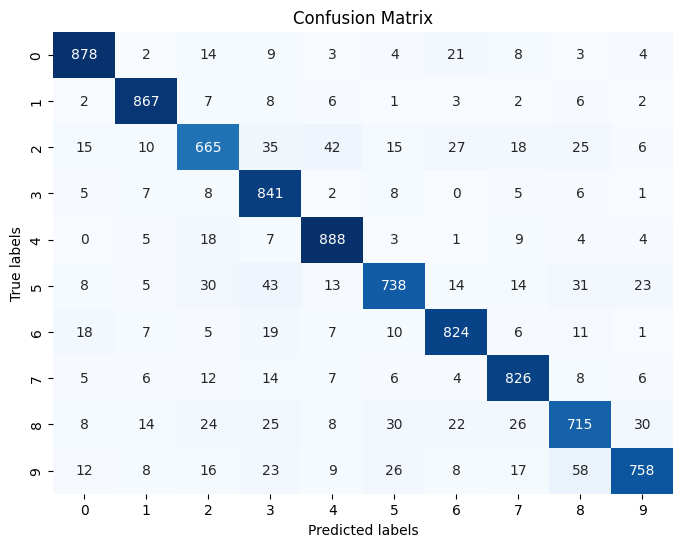

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
# Mostrar la matriz de confusión utilizando seaborn y matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()